# Probabilistic reasoning via WMC

Mario Tapia Montero (ID 2081407)

Note: Clean version of 3.5 
(simplified for cycle when calculating models of phi)

### Importing required libraries

In [1]:
from pysat.solvers import Minisat22
from pysat.formula import CNF
import bnlearn as bn
from tabulate import tabulate

### Importing datasets
#### From bnlearn package:
* Sprinkler: 
    - 4 binary variables
    - 1,000 instances
    - The dataset represents a Bayesian network of four binary variables: Cloudy, Sprinkler, Rain, and Wet Grass. The variable Cloudy influences Sprinkler and Rain, which in turn affect Wet Grass.
    
* Asia:
    - 8 binary variables
    - 10,000 instances
    - The dataset represents a Bayesian network of eight binary variables: Dyspnoea, Tuberculosis, Lung Cancer, Bronchitis, Visit to Asia, Smoking, Chest X-ray, and Tuberculosis versus Lung Cancer/Bronchitis. It models the relationships between lung diseases and risk factors
    


In [2]:
datasets = ["sprinkler", "asia"]

dataset = datasets[0] # Imports the data set

df = bn.import_DAG(dataset, CPD = True)
CPDs = bn.print_CPD(df, verbose = 1) # Gather and store the CPD in dictionary contaning dataframes for each node
print(CPDs.keys())

[bnlearn] >Import <sprinkler>
[bnlearn] >Check whether CPDs sum up to one.
dict_keys(['Cloudy', 'Sprinkler', 'Rain', 'Wet_Grass'])


#### Visualizing dataset

In [3]:
df_head = bn.import_example(dataset)
df_head.head()

,Cloudy,Sprinkler,Rain,Wet_Grass
0,0,0,0,0
1,1,0,1,1
2,0,1,0,1
3,1,1,1,1
4,1,1,1,1


#### Plotting the DAG

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


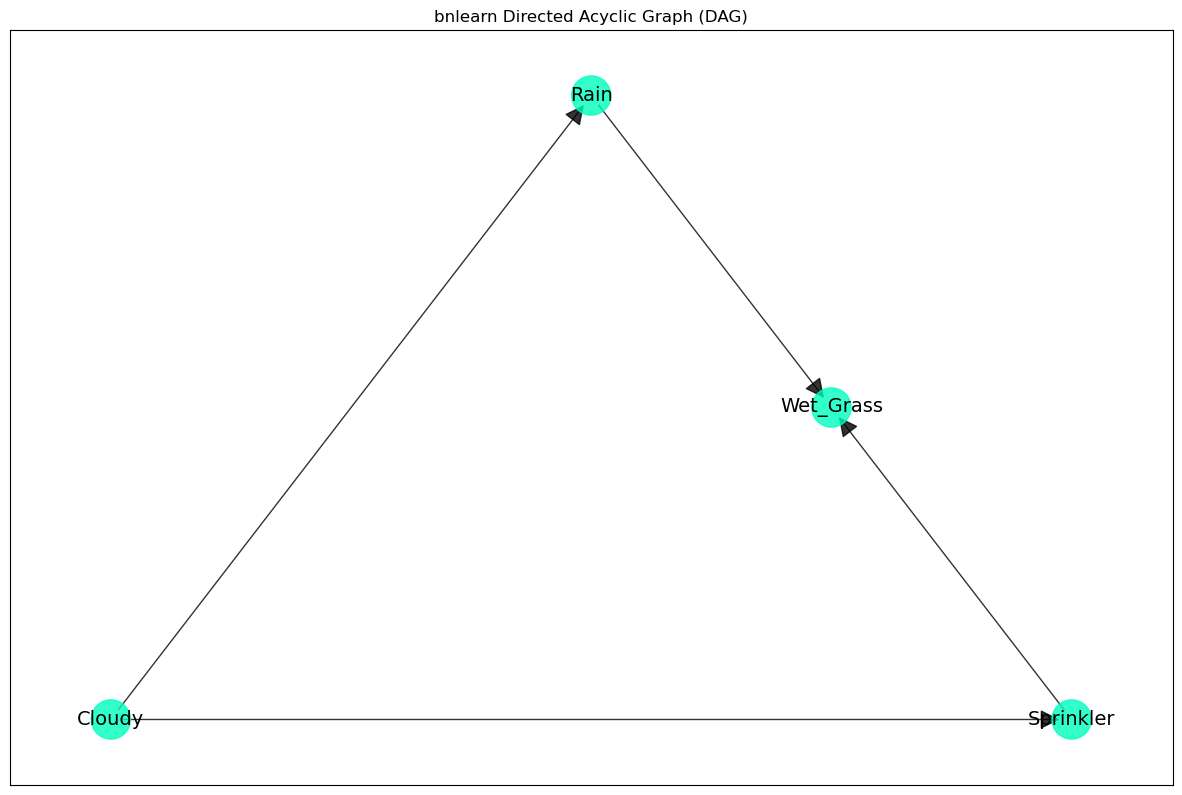

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'Cloudy': array([-1.        , -0.33333333]),
  'Sprinkler': array([ 0.77777778, -0.33333333]),
  'Rain': array([-0.11111111,  0.55555556]),
  'Wet_Grass': array([0.33333333, 0.11111111])},
 'G': <networkx.classes.digraph.DiGraph at 0x1aebbe822b0>,
 'node_properties': {'Cloudy': {'node_color': '#1f456e', 'node_size': 800},
  'Sprinkler': {'node_color': '#1f456e', 'node_size': 800},
  'Rain': {'node_color': '#1f456e', 'node_size': 800},
  'Wet_Grass': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('Cloudy', 'Sprinkler'): {'color': '#000000',
   'weight': 1},
  ('Cloudy', 'Rain'): {'color': '#000000', 'weight': 1},
  ('Sprinkler', 'Wet_Grass'): {'color': '#000000', 'weight': 1},
  ('Rain', 'Wet_Grass'): {'color': '#000000', 'weight': 1}}}

In [4]:
bn.plot(df, interactive=False, node_color='#00FFBD', params_static={"layout": "planar_layout", "arrowstyle":"-|>"}) 

### Functions
#### Checking number of parents of a node

In [5]:
def check_parents(dic_input, key):
    k = len(dic_input[key].columns[1:len(dic_input[key].columns) - 1])
    return k

#### Changing the names of the original variables to integers, so they can be used by Minisat22 solver

In [6]:
def change_key(dic_input):

    dic = dic_input.copy()
    keys_correspondance = {}    # Creates dictionary just for showing the correspondance between
                                # old and new names
    parents = {}  # Creates dictionary with keys corresponding to the nodes with parents
                  # and the values corresponding to a list with the parents in the order
                  # displayed by the CPD from the data set
    i = 1
    for key in list(dic.keys()):    
        dic[i] = dic[key]
        keys_correspondance[key] = i
        del dic[key]
        i += 1
    
    # Rename the columns using the dictionary (they become of type int, to later construct the lists
    # required by Minisat22)
    for key in dic.keys():
        k = check_parents(dic, key)
        if k >= 1:
            parents[key] = [keys_correspondance[x] for x in dic[key].columns.values[1:-1]]
    
    for key in dic.keys():
        dic[key].rename(columns=keys_correspondance, inplace=True)
    
    return keys_correspondance, parents, dic

#### Encoding the Bayesian network in WMC

In [7]:
def pb_prop_formula(dic_input):
    
    dic_weights = {}
    f1 = CNF()
    m = max(list(dic_input.keys()))
    for key in dic_input.keys():
        k = check_parents(dic_input, key)
        if k == 0:
            val = dic_input[key].loc[dic_input[key].iloc[:, 0] == 1].loc[:,"p"].iloc[0]   # From the dictionary, we select the rows that have value 1 in the first column (the value of the variable), and then retrieve the probability value from column "p"
            dic_weights[key] = val
            dic_weights[-key] = round(1 - val, 6)
        else:
            dic_weights[key] = 1
            dic_weights[-key] = 1
            for i in dic_input[key].loc[dic_input[key].iloc[:, 0] == 1].index.values:
                m += 1
                dic_weights[m] = dic_input[key]["p"][i]
                dic_weights[-m] = round(1 - dic_input[key]["p"][i], 6)
                
                L1 = [-m, key] 
                L2 = [m, -key] 
                
                for j in dic_input[key].iloc[:,1:-1].columns.values:
                    if dic_input[key].iloc[i][j] == 0:
                        L1.append(j)
                        L2.append(j)
                    else:
                        L1.append(-j)
                        L2.append(-j)
                
                f1.append(L1)  
                f1.append(L2)  
                
    return dic_weights, f1

#### Mapping each variable appearing as a model to its weight

In [8]:
def weight_function(dic, set_keys):
    values = []
    for key in set_keys:
        values.append(dic[key])
    return values

#### Multiply the elements of a list (weights of a single model)

In [9]:
def multiply_list_elements(lst):
    product = 1
    for num in lst:
        product *= num
    return product

### Creating the keys correspondance dictionary, parents correspondance dictionary and CPD tables

In [10]:
cor, par, CPD = change_key(CPDs)

In [11]:
print("- 'cor' dictionary is:", cor)
print("- 'par' dictionary is:", par)
print("- 'CPD' for variable 1:")
print(tabulate(CPD[1], tablefmt="grid", headers="keys"))
print("- 'CPD' for variable 2:")
print(tabulate(CPD[2], tablefmt="grid", headers="keys"))

- 'cor' dictionary is: {'Cloudy': 1, 'Sprinkler': 2, 'Rain': 3, 'Wet_Grass': 4}
- 'par' dictionary is: {2: [1], 3: [1], 4: [2, 3]}
- 'CPD' for variable 1:
+----+-----+-----+
|    |   1 |   p |
+====+=====+=====+
|  0 |   0 | 0.5 |
+----+-----+-----+
|  1 |   1 | 0.5 |
+----+-----+-----+
- 'CPD' for variable 2:
+----+-----+-----+-----+
|    |   2 |   1 |   p |
+====+=====+=====+=====+
|  0 |   0 |   0 | 0.5 |
+----+-----+-----+-----+
|  1 |   0 |   1 | 0.9 |
+----+-----+-----+-----+
|  2 |   1 |   0 | 0.5 |
+----+-----+-----+-----+
|  3 |   1 |   1 | 0.1 |
+----+-----+-----+-----+


### Probabilistic inference using bnlearn library functions (for comparison purposes)

In [12]:
# Sprinkler dataset:
if dataset == "sprinkler":
    model = bn.import_DAG('sprinkler')
    #q1 = bn.inference.fit(model, variables=['Wet_Grass'], evidence={'Rain':1, "Sprinkler":0, "Cloudy":1}, joint = True)
    #q1 = bn.inference.fit(model, variables=['Rain'], evidence={'Cloudy':1})
    q1 = bn.inference.fit(model, variables=['Wet_Grass'], evidence = {"Rain":1})
    
# Asia dataset:
if dataset == "asia":
    model = bn.import_DAG('asia')
    q1 = bn.inference.fit(model, variables=['xray'], evidence={"asia":1, "bronc":1, "dysp":0, "either":1, 'lung':1, "smoke":0, "tub":1})

[bnlearn] >Import <sprinkler>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-------------+--------+
|    |   Wet_Grass |      p |
+====+=============+========+
|  0 |           0 | 0.0838 |
+----+-------------+--------+
|  1 |           1 | 0.9162 |
+----+-------------+--------+


### Probabilistic inference using WMC
#### Creating weights dictionary and propositional formula $\Phi_B$ in CNF

In [13]:
dic_weights, f1 = pb_prop_formula(CPD)

#### Checking the sum of models of $\Phi_B$

In [14]:
check_sum = 1
if check_sum == 1:
    WMC_phi = 0
    phi_b = Minisat22(bootstrap_with=f1)

    for models in phi_b.enum_models():  
        WMC_phi += multiply_list_elements(weight_function(dic_weights, models)) 

    print(round(WMC_phi, 6))

1.0


#### Adding evidence (denominator)

In [15]:
# Sprinkler dataset:
if dataset == "sprinkler":
    #f1.append([-cor["Cloudy"]])
    f1.append([cor["Rain"]])
    #f1.append([-cor["Sprinkler"]])
    #f1.append([cor["Wet_Grass"]])
    #pass

# Asia dataset:
if dataset == "asia":
    f1.append([-cor["dysp"]])
    f1.append([cor["either"]])
    f1.append([cor["lung"]])
    f1.append([-cor["smoke"]])
    f1.append([cor["tub"]])
    f1.append([cor["asia"]])
    f1.append([cor["bronc"]])
    #pass
    
s1 = Minisat22(bootstrap_with=f1)

WMC_den = 0
for models in s1.enum_models():  
    #print(models)
    WMC_den += multiply_list_elements(weight_function(dic_weights, models)) 


#### Adding query (numerator)

In [16]:
# Sprinkler dataset:
if dataset == "sprinkler":
    f1.append([cor["Wet_Grass"]])
    #f1.append([cor["Cloudy"]])
    #f1.append([-cor["Rain"]])
    #f1.append([-cor["Sprinkler"]])
    
# Asia dataset:
if dataset == "asia":
    f1.append([cor["xray"]])


s2 = Minisat22(bootstrap_with=f1)

WMC_num = 0
for models in s2.enum_models():  
    #print(models)
    WMC_num += multiply_list_elements(weight_function(dic_weights, models)) 


#### Final result

In [17]:
# print("WMC_num", WMC_num, "WMC_den", WMC_den)
print(round(WMC_num / WMC_den, 6))

0.9162


In [ ]:
# Example from bnlearn library documentation

# https://github.com/erdogant/bnlearn/blob/master/README.md

model = bn.import_DAG('sprinkler')
query = bn.inference.fit(model, variables=['Rain'], evidence={'Cloudy':1,'Sprinkler':0, 'Wet_Grass':1})
print(query)
   
    # Lets try another inference
query = bn.inference.fit(model, variables=['Rain'], evidence={'Cloudy':1})
print(query)